# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente.<br>
**Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

*Considero que el Proyecto podría entenderse como un problema de multi-clasificación, donde cada clase corresponde a un valor de estrella. No sería del todo preciso usar regresión porque no buscamos valores continuos, sino más bien discretos y que agrupen a las reseñas según el tipo de valoración que representan.*

## Objetivo del Proyecto
Implementar un modelo para reconocer el puntaje asignado por un usuario a un item de Amazon  partir de su crítica.

## Desarrollo
#### Importamos las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Garbage collector para optimizar recursos
import gc

#### Importamos el dataset de desarrollo

In [2]:
# Importamos dataset de desarrollo
data = pd.read_json("dataset_amazon/dataset_es_dev.json", lines = True)

In [17]:
# Importamos dataset de entrenamiento
data = pd.read_json("dataset_amazon/dataset_es_train.json", lines = True)

Exploramos el dataset para entender los datos:

In [3]:
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [4]:
data.tail()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
4995,es_0179515,product_es_0158275,reviewer_es_0273644,5,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,es,home
4996,es_0894902,product_es_0953259,reviewer_es_0153773,5,Desempeña su función correctamente,calidad precio,es,camera
4997,es_0760496,product_es_0731995,reviewer_es_0171091,5,Me ha encantado la diadema! Las flores son tal...,Excelente,es,toy
4998,es_0178380,product_es_0402051,reviewer_es_0686937,5,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,es,wireless
4999,es_0810087,product_es_0684221,reviewer_es_0613091,5,El artículo ha cumplido con las expectativas q...,Buena calidad,es,apparel


In [6]:
data.shape

(5000, 8)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   stars             5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


In [24]:
# Para ver si hay nulos por columna
data.isna().sum()

review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
dtype: int64

#### Importamos librerías SpaCy y NLTK

Luego de investigar en la documentación de SpaCy y NLTK para ver cuáles stopwords eran más convenientes, vi que [SpaCy](https://github.com/explosion/spaCy/blob/master/spacy/lang/es/stop_words.py) era más completa que [NLTK](https://github.com/Alir3z4/stop-words/blob/bd8cc1434faeb3449735ed570a4a392ab5d35291/spanish.txt). Leyendo un poco sobre eso, descubrí que están sacadas del ámbito de las noticias y por eso tienen más vocabulario que forme parte de las 'stopwords'.

La librería NLTK es más acotada pero clásica, con palabras que bien podrían saltearse en un procesamiento de lenguaje natural. Lo que sí, ambas tienen palabras que nos podrían servir para predecir el valor de una reseña, como 'no', 'bueno', 'buena' y 'buen'.

Para este proyecto voy a elegir **SpaCy** por ser más completa, pero no descarto la posibilidad de entrenarlo con las stopwords de NLTK para evaluar si mejora en algo.

También iré alternando de librerías para los distintos procesos según la facilidad con la que se pueda utilizar cada una.

In [5]:
# Previamente
## python -m spacy download es
## python -m spacy download es_core_news_sm

import spacy # https://spacy.io/usage/models
nlp = spacy.load('es_core_news_sm')

#Stop Words de es_core_news_sm
from spacy.lang.es.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

# Quitamos de las stopwords palabras como 'no', 'bueno', 'buena' que nos pueden ser últiles para predecir
stopwords_spacy.remove('no') # En los comentarios negativos es muy repetida
stopwords_spacy.remove('bueno')
stopwords_spacy.remove('buena')

In [6]:
import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('spanish'))

# Quitamos de las stopwords la palabra 'no', que nos puede ser últil para predecir
stopwords_nltk.remove('no')

import re
from nltk.tokenize import RegexpTokenizer

### Análisis Exploratorio de Datos
#### Algunas preguntas que van surgiendo...
##### 1. ¿Cuántos tipos de productos hay en el dataset?

In [7]:
data.product_category.value_counts()

wireless                    672
home                        659
toy                         332
sports                      331
home_improvement            299
pc                          273
electronics                 251
beauty                      195
automotive                  173
kitchen                     156
book                        142
drugstore                   137
furniture                   135
apparel                     133
baby_product                117
office_product              112
other                       103
luggage                     101
lawn_and_garden             101
pet_products                 89
personal_care_appliances     77
camera                       64
shoes                        60
digital_ebook_purchase       51
watch                        47
musical_instruments          46
video_games                  43
jewelry                      34
industrial_supplies          34
grocery                      33
Name: product_category, dtype: int64

##### 2. ¿Cuántas reseñas hay por cada estrella según la categoría?

In [8]:
data_grouped = data.review_id.groupby([data['product_category'],data['stars']]).count().astype(int).reset_index(name='count')
data_grouped

,product_category,stars,count
0,apparel,1,20
1,apparel,2,30
2,apparel,3,36
3,apparel,4,26
4,apparel,5,21
...,...,...,...
145,wireless,1,164
146,wireless,2,135
147,wireless,3,130
148,wireless,4,127


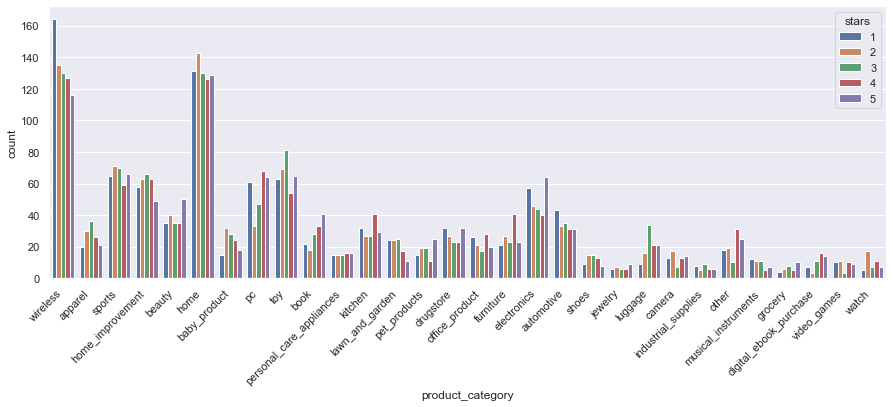

In [9]:
# Visualización
plt.figure(figsize=(15,5))
grafico = sns.countplot(x=data['product_category'],data=data, hue='stars')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

##### 3. ¿Cuál es el promedio de estrellas por cada categoría? Así es más fácil visualizar. <br>
*La media debería dar alrededor de 3, pero aquellos que estén por debajo significa que fueron en su mayoría peor calificados. Inversamente sucede con los que están por encima de 3, lo que significa que fueron en su mayoría muy bien calificados.*

In [10]:
from statistics import mean
data_grouped = data.stars.groupby([data['product_category']]).mean().reset_index(name='avg_stars')
data_grouped['rev_count'] = data.stars.groupby([data['product_category']]).count().astype(int).reset_index(name='rev_count').rev_count
data_grouped.sort_values(by='avg_stars')

,product_category,avg_stars,rev_count
18,musical_instruments,2.652174,46
16,lawn_and_garden,2.673267,101
29,wireless,2.845238,672
1,automotive,2.849711,173
13,industrial_supplies,2.911765,34
27,video_games,2.930233,43
24,shoes,2.933333,60
12,home_improvement,2.939799,299
19,office_product,2.955357,112
28,watch,2.957447,47


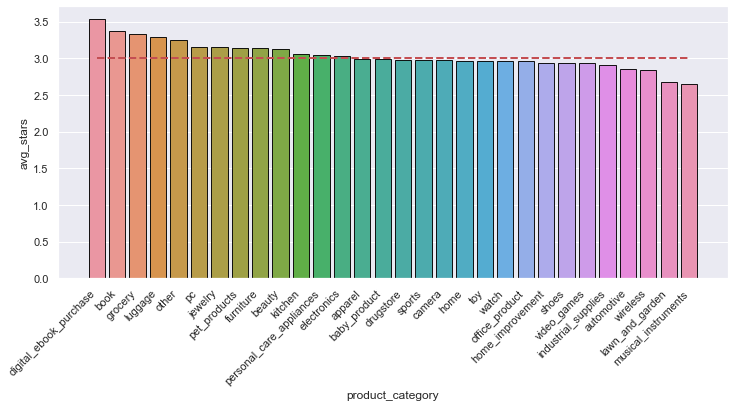

In [11]:
# Visualización de valoración promedio por categoría
data_grouped.sort_values(['avg_stars','rev_count'],ascending=False,inplace=True)
cte = np.ones(data_grouped.shape[0])*3 # Valor medio
plt.figure(figsize=(12,5))
grafico = sns.barplot(x=data_grouped.product_category, y=data_grouped.avg_stars, linewidth=0.9,edgecolor=(0,0,0))
plt.plot(cte, ls = '--', lw = 2, c='r',label = 'Valoración media')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

##### 4. ¿Cuántas reviews hay por cada valoración?

In [23]:
data.stars.value_counts()

4    1000
1    1000
5    1000
2    1000
3    1000
Name: stars, dtype: int64

*Vemos que está equilibrada la cantidad de cada una.*

##### 5. ¿Cuántos usuarios únicos publicaron en este dataset?

In [12]:
# Ver cuántos usuarios únicos publicaron
unique_usrs = len(data.reviewer_id.unique())
print("De las", data.shape[0],"reseñas,", unique_usrs, "fueron hechas por usuarios únicos.")
print("Esto equivale al", unique_usrs/data.shape[0]*100,"%")

De las 5000 reseñas, 4982 fueron hechas por usuarios únicos.
Esto equivale al 99.64 %


##### 6. ¿Cuántos productos únicos aparecen en las reseñas?

In [13]:
# Ver sobre cuántos productos únicos se publicaron reseñas
unique_prods = len(data.product_id.unique())
print("De las", data.shape[0],"reseñas, se mencionan", unique_prods , "productos únicos.")
print("Esto equivale al", unique_prods/data.shape[0]*100,"%")

De las 5000 reseñas, se mencionan 4964 productos únicos.
Esto equivale al 99.28 %


##### 7. Tomamos como ejemplo un usuario y analizamos su actividad

In [14]:
# Vemos las reseñas de un solo usuario
rand_idx = np.random.randint(0,data.shape[0])
usr = data.reviewer_id.iloc[rand_idx]
usr_data = data[data.reviewer_id == usr]
print("Cantidad de reseñas del usuario", usr,":", len(usr_data))
print("Promedio de estrellas que ha dado:", usr_data.stars.mean())
usr_data[['reviewer_id','product_category','review_title','review_body','stars']]

Cantidad de reseñas del usuario reviewer_es_0747606 : 1
Promedio de estrellas que ha dado: 3.0


,reviewer_id,product_category,review_title,review_body,stars
2134,reviewer_es_0747606,home,Se oxidan,"Funcionan bien, son de un tamaño pequeño y man...",3


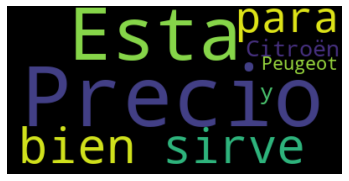

In [16]:
# pip install wordcloud
from wordcloud import WordCloud
wordcloud = WordCloud().generate(usr_data.review_title.iloc[0] + ' ' + usr_data.review_body.iloc[0])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### 8. ¿Cuáles son las palabras más frecuentes por cada valoración?
Para responder a esto neceitamos importar la librería NLTK para el procesamiento del lenguaje natural.

In [15]:
# Separamos en distintos dataframes las reviews según valoración
data_star_1 = data[data['stars']==1]
data_star_2 = data[data['stars']==2]
data_star_3 = data[data['stars']==3]
data_star_4 = data[data['stars']==4]
data_star_5 = data[data['stars']==5]

Empezamos analizando las reviews de 1 estrella:

In [16]:
todas_reviews_1 = []
for i in data_star_1.index:
    review1 = data_star_1.review_body[i] #seleccionar el titular
    sent = nlp(review1.lower())
    for token in sent:
        if (token.pos_ == "ADJ" and token not in stopwords_spacy):
            temp = token.lemma_
            todas_reviews_1.append(temp) #agregar el resultado a la lista

print('- Cantidad de palabras filtradas:',len(todas_reviews_1))
todas_reviews_1[:3]

- Cantidad de palabras filtradas: 1951


['malisimo', 'grande', 'aparatoso']

In [17]:
# Obtenemos frecuencia de palabras y creamos nuevo df
freq_rev_1 = nltk.FreqDist(todas_reviews_1)
df_rev_frec_1 = pd.DataFrame(freq_rev_1.items(), columns = ['Palabra', 'Frecuencia']) 
df_rev_frec_1.sort_values(by=['Frecuencia'], inplace=True, ascending=False)
df_rev_frec_1.reset_index(drop = True, inplace=True)
df_rev_frec_1.head()

,Palabra,Frecuencia
0,malo,89
1,primero,48
2,roto,41
3,pequeño,35
4,solo,33


In [18]:
# Vemos la parte inferior
df_rev_frec_1[df_rev_frec_1['Frecuencia']<10]

,Palabra,Frecuencia
32,superior,9
33,difícil,9
34,negro,9
35,horrible,9
36,trasero,9
...,...,...
714,ampliado,1
715,saludo,1
716,estable,1
717,junto,1


##### Visualizamos la frecuencia de las palabras en las reviews de 1 estrella

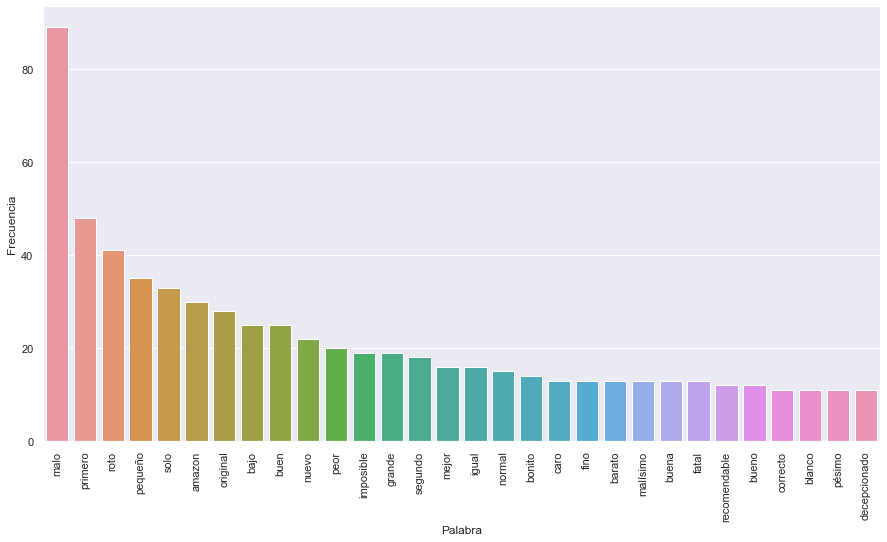

In [19]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_1.iloc[:30].Palabra, y = df_rev_frec_1.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [31]:
from wordcloud import WordCloud

# Definimos función para ver el wordcloud de una lista de palabras
def ver_wordcloud(palabras):
    text = ' '.join(palabras)
    wordcloud = WordCloud().generate(text.strip())
    plt.figure(figsize = (15,8), facecolor = None)
    plt.imshow(wordcloud, interpolation='kaiser')
    plt.axis("off")
    plt.show()

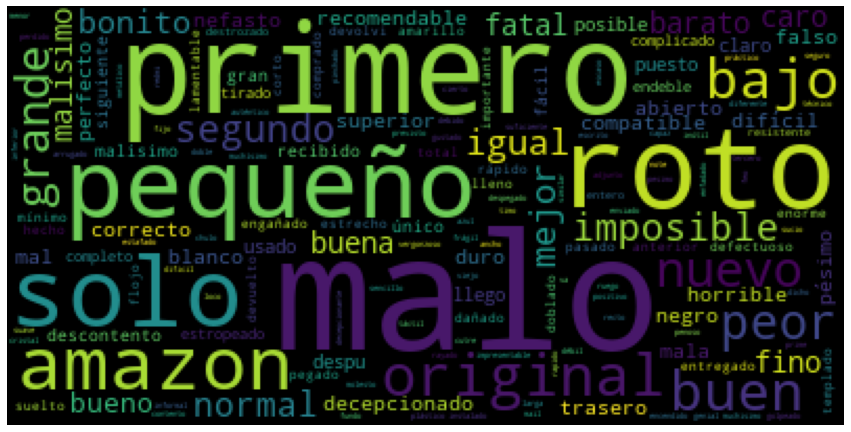

In [32]:
ver_wordcloud(todas_reviews_1)

*Palabras como 'Amazon', 'primero' y 'segundo' se repiten mucho pero no son relevantes.*

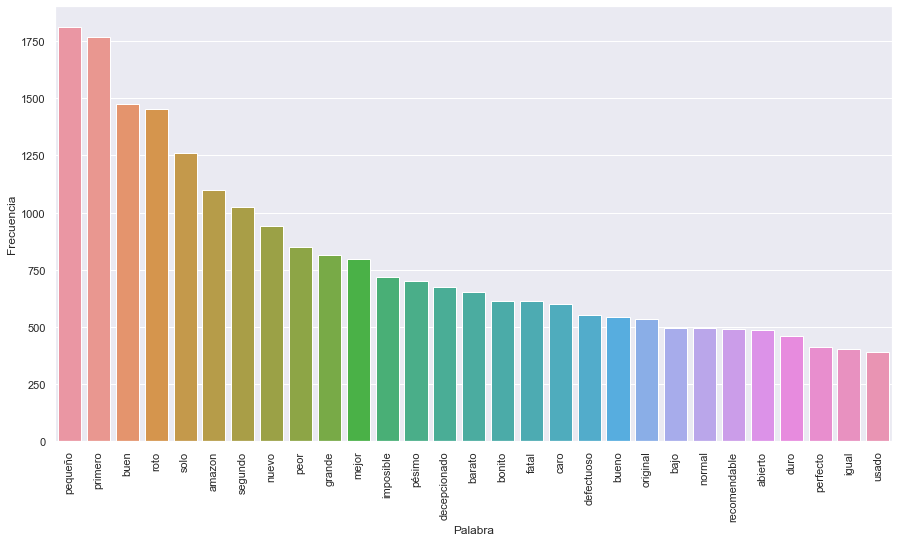

In [39]:
# Filtramos la palabra 'no' que es ampliamente más frecuente para visualizar mejor
# plt.figure(figsize = (15,8))
# plot = sns.barplot(x  = df_rev_frec_1.iloc[1:30].Palabra, y = df_rev_frec_1.iloc[1:30].Frecuencia)
# for item in plot.get_xticklabels():
#    item.set_rotation(90)
# plt.show()

Para procesar los restantes dataframes, agrupamos todas las operaciones en una sola función:

In [38]:
def adj_list(dataframe):
    todas_reviews = []
    for i in dataframe.index:
        review1 = dataframe.review_body[i] #seleccionar el titular
        sent = nlp(review1.lower())
        # review1 = RegexpTokenizer('\w+').tokenize(review1) # Tokenizar con RegexpTokenizer
        for token in sent:            
            if (token.pos_ == "ADJ" and str(token) not in stopwords_spacy):
                temp = token.lemma_
                todas_reviews.append(temp) #agregar el resultado a la lista
    return todas_reviews

def adj_frecquency_df(todas_reviews):
    # plain_todas_reviews = list(itertools.chain(*todas_reviews)) # Aplanar la lista
    freq_revs = nltk.FreqDist(todas_reviews) # Obtener frecuencia por palabra
    df_revs = pd.DataFrame(freq_revs.items(), columns = ['Palabra', 'Frecuencia']) # Crear nuevo df
    df_revs.sort_values(by=['Frecuencia'], inplace=True, ascending=False) # Ordenar valores por frecuencia
    df_revs.reset_index(drop = True, inplace=True) # Resetear index
    return df_revs

In [36]:
# Listamos los adjetivos de las reviews con 5 estrellas
todas_reviews_5 = adj_list(data_star_5)

In [39]:
df_rev_frec_5 = adj_frecquency_df(todas_reviews_5)
df_rev_frec_5

,Palabra,Frecuencia
0,buen,170
1,perfecto,155
2,bonito,63
3,fácil,55
4,rápido,55
...,...,...
678,aconsejable,1
679,reflectante,1
680,mullida,1
681,higiénica.cumple,1


##### Visualizamos la frecuencia de las palabras en las reviews de 5 estrellas

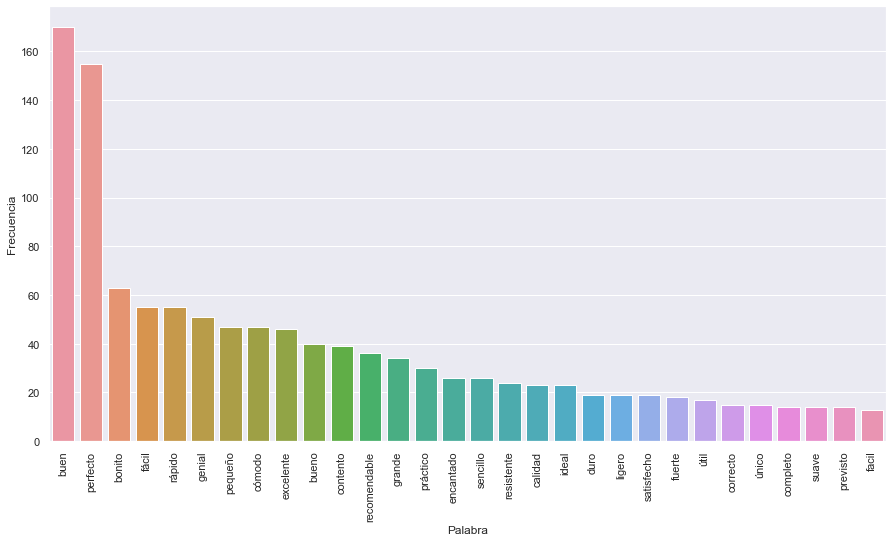

In [40]:
# Generamos gráfico con valores
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_rev_frec_5.iloc[:30].Palabra, y = df_rev_frec_5.iloc[:30].Frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

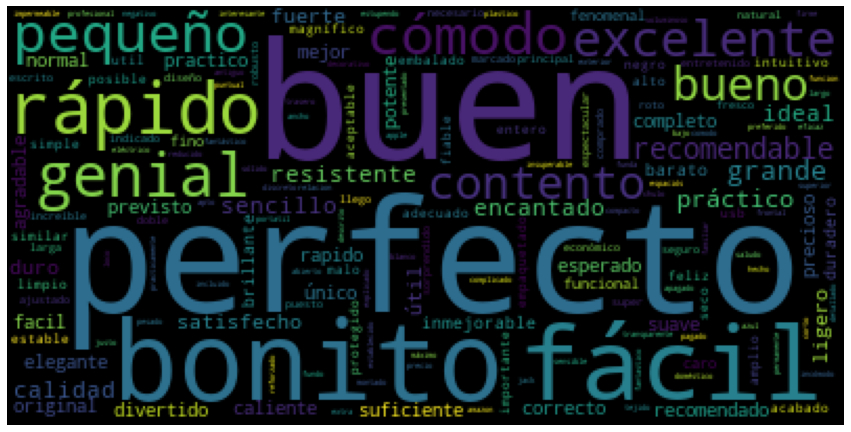

In [41]:
ver_wordcloud(todas_reviews_5)

In [42]:
# limpiamos memoria
gc.collect()

24130

### Preprocesamiento
#### Importamos el dataset de entrenamiento
Importamos dataset que será utilizado para *train* y nos quedamos con las columnas relevantes.

In [44]:
# Set de entrenamiento
train_data = pd.read_json("dataset_amazon/dataset_es_train.json", lines = True)
train_df = train_data[['product_category','review_title','review_body','stars']]
train_df.head()

,product_category,review_title,review_body,stars
0,electronics,television Nevir,Nada bueno se me fue ka pantalla en menos de 8...,1
1,electronics,Dinero tirado a la basura con esta compra,"Horrible, nos tuvimos que comprar otro porque ...",1
2,drugstore,solo llega una unidad cuando te obligan a comp...,Te obligan a comprar dos unidades y te llega s...,1
3,wireless,PRODUCTO NO RECIBIDO.,"No entro en descalificar al vendedor, solo pue...",1
4,shoes,Devuelto,Llega tarde y co la talla equivocada,1


In [45]:
print("- Cantidad de filas total del set de entrenamiento:", train_df.shape[0])
print("- Cantidad de filas nulas por columna:")
train_df.isna().sum()

- Cantidad de filas total del set de entrenamiento: 200000
- Cantidad de filas nulas por columna:


product_category    0
review_title        0
review_body         0
stars               0
dtype: int64

#### Importamos el dataset de prueba
Importamos dataset que será utilizado para *test* y nos quedamos con las columnas relevantes.

In [47]:
test_data = pd.read_json("dataset_amazon/dataset_es_test.json", lines = True)
test_df = test_data[['product_category','review_title','review_body','stars']]
test_df.head()

,product_category,review_title,review_body,stars
0,wireless,no me llego,no me llego el articulo me lo mando por correo...,1
1,home,amazon sigue sin cumplir en las entregas,"la mensajería horrible, no compro mas",1
2,toy,ESTAFA EN EL ENVÍO,Estoy muy decepcionado con el vendedor ya que ...,1
3,home,Estafa de Amazon,Mi valoración no es sobre el producto sino sob...,1
4,digital_ebook_purchase,No conseguí pasar de la portada en Kindle,Pues tenía interés en este libro y probé la ve...,1


In [48]:
print("- Cantidad de filas total del set de prueba:", test_df.shape[0])
print("- Cantidad de filas nulas por columna:")
test_df.isna().sum()

- Cantidad de filas total del set de prueba: 5000
- Cantidad de filas nulas por columna:


product_category    0
review_title        0
review_body         0
stars               0
dtype: int64

Como el set de prueba es muy menor al set de entrenamiento (representa un 2,5% de los datos), vamos a juntar ambos datasets y con el `train_test_split` tomar un 30% para *test*.

Además, esto permite reducir la carga de entrenamiento.

In [ ]:
#df = pd.concat([train_df,test_df])
#df.tail()

#### Tokenización y Lemmatización

In [49]:
# Miramos una review al azar
random_index = np.random.randint(0,train_df.shape[0])
review = train_df.review_body.iloc[random_index]
title = train_df.review_title.iloc[random_index]
print(random_index, title, '\n',review)
print('- Valoración:',train_df.stars[random_index])
print('- Categoría:', train_df.product_category[random_index])

58810 No funciona. 
 En mi caso, y siguiendo claramente las instrucciones (mirando también videos en YT) no me ha dado resultado. Se ha empapado la parte baja la guantera, ha olido bien durante la aplicación, pero al día siguiente al utilizar el vehículo y al poner la calefacción, continuaba el mal olor.
- Valoración: 2
- Categoría: automotive


In [50]:
# Mostramos las POS de la review elegida
sent = nlp(review)
for token in sent:
    print(token,"-",token.pos_)

En - ADP
mi - DET
caso - NOUN
, - PUNCT
y - CCONJ
siguiendo - VERB
claramente - ADV
las - DET
instrucciones - NOUN
( - PUNCT
mirando - VERB
también - ADV
videos - NOUN
en - ADP
YT - PROPN
) - PUNCT
no - ADV
me - PRON
ha - AUX
dado - VERB
resultado - NOUN
. - PUNCT
Se - PRON
ha - AUX
empapado - VERB
la - DET
parte - NOUN
baja - ADJ
la - DET
guantera - NOUN
, - PUNCT
ha - AUX
olido - VERB
bien - ADV
durante - ADP
la - DET
aplicación - NOUN
, - PUNCT
pero - CCONJ
al - ADP
día - NOUN
siguiente - ADJ
al - ADP
utilizar - VERB
el - DET
vehículo - NOUN
y - CCONJ
al - ADP
poner - VERB
la - DET
calefacción - NOUN
, - PUNCT
continuaba - VERB
el - DET
mal - ADJ
olor - NOUN
. - PUNCT


In [51]:
# Visualización
# from spacy import displacy
# displacy.serve(sent, style="dep")

C:\Users\Luli\.conda\envs\datascience\lib\site-packages\spacy\displacy\__init__.py:97: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


In [52]:
# Tokens lemmatizados de la review elegida
for token in sent:
    print(token,"-",token.lemma_)

En - en
mi - mi
caso - caso
, - ,
y - y
siguiendo - seguir
claramente - claramente
las - el
instrucciones - instrucción
( - (
mirando - mirar
también - también
videos - video
en - en
YT - YT
) - )
no - no
me - yo
ha - haber
dado - dar
resultado - resultado
. - .
Se - él
ha - haber
empapado - empapar
la - el
parte - parte
baja - bajo
la - el
guantera - guantera
, - ,
ha - haber
olido - oler
bien - bien
durante - durante
la - el
aplicación - aplicación
, - ,
pero - pero
al - al
día - día
siguiente - siguiente
al - al
utilizar - utilizar
el - el
vehículo - vehículo
y - y
al - al
poner - poner
la - el
calefacción - calefacción
, - ,
continuaba - continuar
el - el
mal - mal
olor - olor
. - .


In [55]:
#Constante de signos de puntuación
import string
puntua = string.punctuation + '¡¿...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X','PROPN']

#Función para limpieza de datos
def text_data_cleaning(sentence):
    doc = nlp(sentence)
    
    clean_tokens = []
    for token in doc:
        if (token.pos_ not in excluded_pos and str(token) not in stopwords_spacy): 
            temp = token.lemma_.strip()
            clean_tokens.append(temp.lower())
    
    return clean_tokens

In [56]:
# Limpiamos la review escogida
clean_review = text_data_cleaning(review)
clean_review

['caso',
 'seguir',
 'claramente',
 'instrucción',
 'mirar',
 'video',
 'no',
 'resultado',
 'empapar',
 'bajo',
 'guantera',
 'oler',
 'aplicación',
 'utilizar',
 'vehículo',
 'calefacción',
 'continuar',
 'olor']

In [57]:
gc.collect()

136

In [58]:
# Limpiamos todas las reviews
clean_reviews = []
for i in train_df.index:
    rev = text_data_cleaning(train_df.review_title.iloc[i] + ' ' + train_df.review_body.iloc[i])
    #rev = [" ".join(w) for w in rev]
    clean_reviews.append(rev)

In [59]:
clean_reviews

[['t e l e v i s i o n',
  'n a d a',
  'b u e n o',
  'p a n t a l l a',
  'm e s',
  'n o',
  'r e c i b i r',
  'r e s p u e s t a',
  'f a b r i c a n t e'],
 ['t i r a d o',
  'b a s u r a',
  'c o m p r a',
  't e n e r',
  'c o m p r a r',
  'i n g l é s',
  'i n f o r m á t i c o',
  'h o r a',
  'c a p a z',
  'i n s t a l a r   é l'],
 ['l l e g a r',
  'u n i d a d',
  'o b l i g a r',
  'c o m p r a r',
  'o b l i g a r',
  'c o m p r a r',
  'u n i d a d',
  'l l e g a r',
  'n o',
  'f o r m a',
  'r e c l a m a r',
  'a u t e n t i c o',
  'e s t a f a',
  'n o',
  'c o m p r e i'],
 ['n o',
  'n o',
  'e n t r o',
  'd e s c a l i f i c a r',
  'v e n d e d o r',
  'm e s',
  'e s p e r a',
  's e g u i r',
  'p r o d u c t o',
  't e n e r',
  'c o n t a c t a r',
  'r e c l a m a r',
  'r e e m b o l s o',
  'a m a z o n',
  'c a r g o',
  'p r o b l e m a',
  'd e s e m b o l s a r',
  'd i n e r o',
  'm e s',
  'd e v o l v e r',
  't o t a l',
  'p a l a b r a',
 

In [ ]:
# Agregamos columna al dataset
train_df['clean_rev'] = clean_reviews
train_df.head()

### Vectorización

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_test = TfidfVectorizer()

# Seleccionamos las columnas de interés
df_lemm = train_df.loc[:,('clean_rev','stars')]
df_lemm.head()

In [ ]:
list_revs = list(df_lemm['clean_rev'].values)
stars = df_lemm['stars'].values
#stars
#list_revs = [" ".join(w) for w in list_revs] # Juntamos las palabras en un solo string por cada fila
#list_revs

In [ ]:
matriz_revs = tfidf.fit_transform(list_revs)
matriz_revs

In [ ]:
matriz_revs.toarray()

In [ ]:
# Tomamos las palabras
all_words = tfidf.get_feature_names()
print("Palabras más usadas:",all_words[0:50])

In [ ]:
# Hacemos lo mismo con los datos de test
df_lemm = test_df.loc[:,('clean_rev','stars')]
list_test = list(df_lemm['clean_rev'].values)
matriz_test = tfidf_test.fit_transform(list_test)
stars_test = df_lemm['stars'].values

### Modelización

In [ ]:
X_train = matriz_revs.toarray()
y_train = stars
X_test = matriz_test.toarray()
y_test = stars_test

#from sklearn.model_selection import train_test_split
#xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion(ytest,y_pred):
    names=["No Sarcastico","Sarcastico"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Naive Bayes

In [ ]:
nb = GaussianNB()
nb.fit(X_train,y_train)

print("acc : ", nb.score(X_test,y_test))

In [ ]:
y_pred = nb.predict(X_test)
confusion(y_test,y_pred)